In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from quetzal.model import stepmodel
from syspy.skims import skims
from syspy.assignment.raw import fast_assign as assign
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')

In [7]:
# Load road links either from network path or from the
# equilibrium assignment path
if scenario.endswith('equilibrium'):
    road = stepmodel.read_json(model_path + 'de_road_network')
else:
    road = stepmodel.read_json(network_path + 'de_road_network')
sm.road_links = road.road_links

In [8]:
sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [9]:
# Load volumes
volumes_file = 'de_volumes'
v = stepmodel.read_zippedpickles(model_path + volumes_file)
if 'exo' in volumes_file:
    # Rename columns from VP2030 to match the model's demand segments
    car_segment_dict = {'0': '_no_car', '1': '_car'}
    vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                       'Fz4': 'business', 'Fz6': 'leisure'}
    sm.volumes = v.volumes.rename(columns={
        c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
        for c in v.volumes.columns if c.startswith('Fz')
    })
    # Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
    accompany_no_car_share = 101 / 1530
    accompany_car_share = 5569 / 30292
    sm.volumes['accompany'+car_segment_dict['0']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
    sm.volumes['accompany'+car_segment_dict['1']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
        sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)
else:
    sm.volumes = v.volumes

volumes: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


In [10]:
# Number of OD pairs in volumes table
len(set([(o,d) for o,d in zip(sm.volumes['origin'], sm.volumes['destination'])]))

4930600

In [11]:
# Load LoS tables with mode choice probabilities
car = stepmodel.read_zippedpickles(model_path + 'de_road_los')
pt = stepmodel.read_zippedpickles(model_path + 'de_pt_los')

pt_los: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [02:03<00:00, 123.32s/it]


In [12]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) for col in pt.pt_los.columns if '(' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [13]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [14]:
sm.pt_los.sample()

,level_0,index,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
5430835,5430835,5471216,DE734_5,DEG0L_1,"(rail_short,)","(rs_55749, rs_55750, rs_55751, rs_55752, rs_55...",2.0,257127,1768,566.0,...,0.391903,0.020379,0.758864,0.340634,0.947034,0.045611,0.572684,0.052179,1.0,0.007667


In [15]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [16]:
# Number of OD pairs in LoS table
len(set([(o,d) for o,d in zip(sm.los['origin'], sm.los['destination'])]))

4944165

In [17]:
print('Car mode share by segment')
print(sm.car_los[[c for c in sm.car_los.columns if c[1]=='probability']].mean())

Car mode share by segment
(commuting_no_car, probability)      0.007411
(commuting_car, probability)         0.930334
(business_no_car, probability)       0.027506
(business_car, probability)          0.914165
(education_no_car, probability)      0.005463
(education_car, probability)         0.806141
(buy/execute_no_car, probability)    0.011347
(buy/execute_car, probability)       0.974390
(leisure_no_car, probability)        0.035890
(leisure_car, probability)           0.956542
(accompany_no_car, probability)      0.004516
(accompany_car, probability)         0.996896
dtype: float64


## Assignment

The current volumes table contains outward and return trips per OD pair.

In [18]:
# Assign volumes to LoS path table
sm.los.drop(sm.segments + [c for c in sm.los.columns
                           if 'utility' in c or 'price' in c or ('time' in c and len(c)>4)],
            axis=1, inplace=True, errors='ignore')
sm.compute_los_volume(keep_segments=True)
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.car_los = sm.los.loc[sm.los['route_type']=='car']

route_type
air           AxesSubplot(0.125,0.125;0.775x0.755)
bus           AxesSubplot(0.125,0.125;0.775x0.755)
car           AxesSubplot(0.125,0.125;0.775x0.755)
coach         AxesSubplot(0.125,0.125;0.775x0.755)
rail_long     AxesSubplot(0.125,0.125;0.775x0.755)
rail_short    AxesSubplot(0.125,0.125;0.775x0.755)
walk          AxesSubplot(0.125,0.125;0.775x0.755)
Name: length, dtype: object

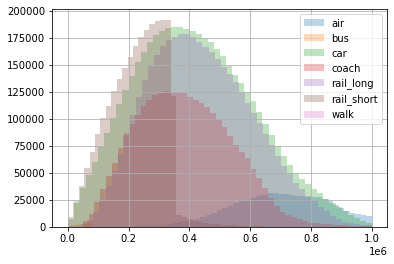

In [20]:
# Show distance-distribution of paths with volumes by mode
sm.los.loc[sm.los['volume']>0].groupby('route_type')['length'].hist(bins=50, alpha=.3, legend=True)

In [21]:
# Create a column for car volumes
merge_cols = ['origin', 'destination']
vols = pd.DataFrame(index=sm.volumes.index)
for seg in sm.segments:
    merged = sm.volumes[merge_cols+[seg]].merge(
        sm.car_los[merge_cols+[(seg, 'probability')]],
        on=merge_cols,
        how='left')
    vols[seg] = (merged[seg] * merged[(seg, 'probability')]).fillna(0)
sm.volumes['volume_car'] = vols[sm.segments].sum(axis=1)
# The same for PT
#vols = pd.DataFrame(index=sm.volumes.index)
#for seg in sm.segments:
#    merged = sm.volumes[merge_cols+[seg]].merge(
#        sm.pt_los[merge_cols+[(seg, 'probability')]],
#        on=merge_cols,
#        how='left')
#    vols[seg] = (merged[seg] * merged[(seg, 'probability')]).fillna(0)
#sm.volumes['volume_pt'] = vols[sm.segments].sum(axis=1)

In [22]:
#sm.links['road_link_list'] = [[] for _ in range(len(sm.links))]
#sm.step_assignment(road=True, segmented=True, compute_los_volume=True)
# Or
#sm.segmented_car_assignment()
#sm.segmented_pt_assignment(split_by='route_type', on_road_links=False, path_column='link_path')

In [23]:
# Assign volumes to network by segment
for segment in tqdm(sm.segments):
    column = 'link_path'
    l = sm.los.dropna(subset=[column])
    sm.links[segment] = assign(l[segment], l[column]).fillna(0)
    sm.road_links[segment] = assign(l[segment], l[column]).fillna(0)
sm.links['volume'] = sm.links[sm.segments].sum(axis=1)
sm.road_links['volume'] = sm.road_links[sm.segments].sum(axis=1)

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [2:06:15<00:00, 631.32s/it]


## Results

In [24]:
# Show pkm (mio.) by disaggregated PT modes
if not 'length' in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(
        sm.links['geometry']).astype(int)
sm.links['pkm'] = sm.links['length']/1000 * sm.links['volume']
sm.links.groupby('route_type').agg({'pkm': 'sum'}) / 1e6

,pkm
route_type,
air,195.249847
bus,66875.875758
coach,5078.999233
rail_long,206434.782885
rail_short,149509.083935


In [25]:
# Share of links with volumes assigned
len(sm.road_links.loc[sm.road_links['volume']>0]) / len(sm.road_links)

0.31351428595097464

In [26]:
# Aggregated pkm of cars (billion)
(sm.road_links['volume'] * sm.road_links['length'] / 1000).sum() / 1e9

607.9672935242769

In [27]:
# Aggregated pkm of cars (billion)
(sm.road_links['volume'] * sm.road_links['length'] / 1000).sum() / 1.5 \
    / params['vehicles']['car']

8818.773165699698

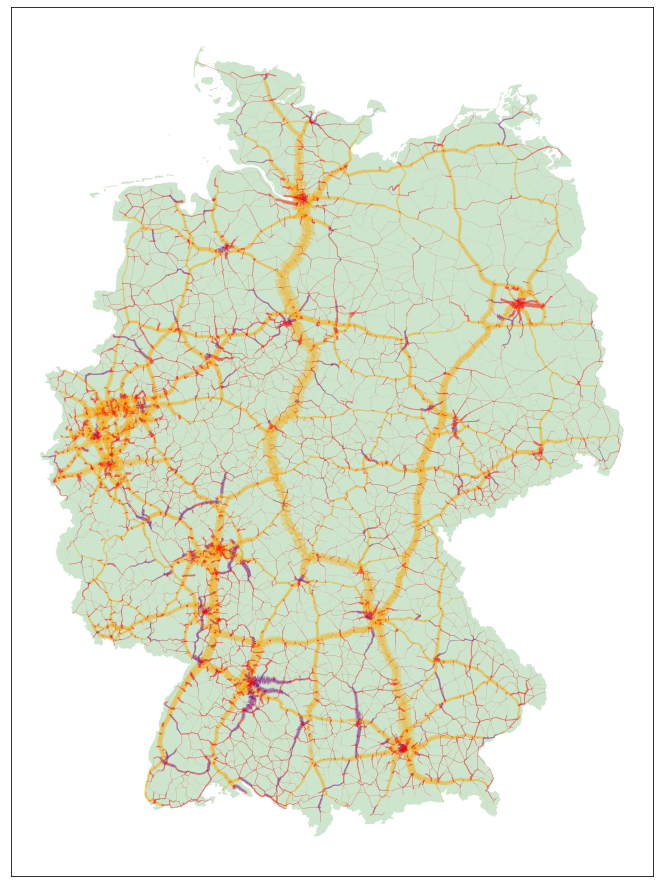

In [82]:
# Plot road assignment
sm.road_links = gpd.GeoDataFrame(sm.road_links)
sm.zones = gpd.GeoDataFrame(sm.zones)
scaler = sm.road_links['volume'].max() / 35
mask = sm.road_links['volume']>0
colors = sm.road_links.loc[mask, 'highway'].map({
    'motorway': 'orange', 'trunk': 'purple', 'primary': 'red', 'secondary': 'red'
}).fillna('red')
sm.road_links.loc[mask, ['geometry']].plot(
    alpha=.3,
    color=list(colors),
    linewidth=list(sm.road_links.loc[mask, 'volume']/scaler),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_all.png', dpi=300)

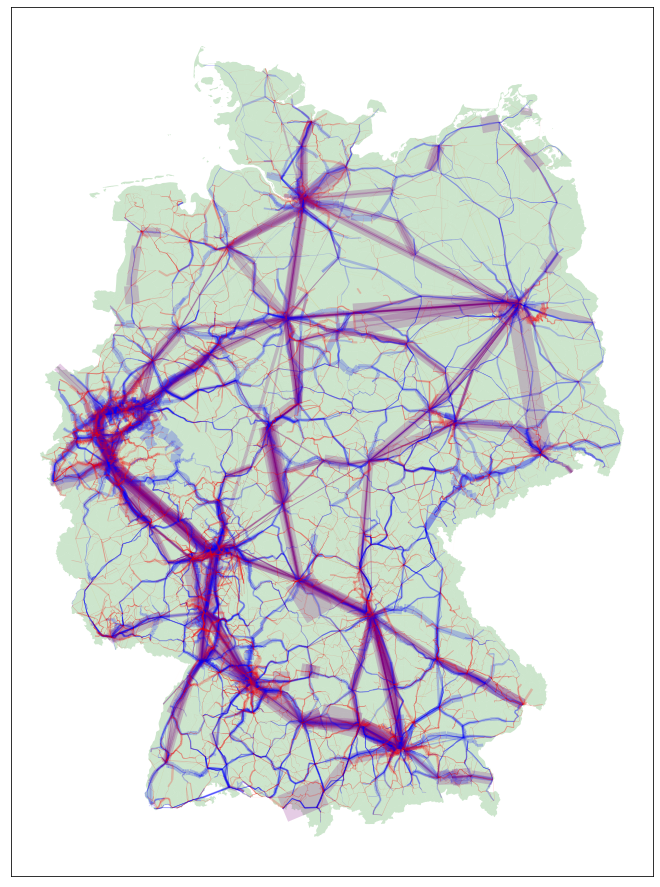

In [83]:
# Only PT
sm.links = gpd.GeoDataFrame(sm.links)
mask = sm.links['volume']>0
colors = sm.links.loc[mask, 'route_type'].map(
    {'rail': 'blue', 'rail_long': 'purple', 'rail_short': 'blue',
     'bus': 'red', 'subway': 'red', 'tram': 'red', 'ferry': 'red', 'funicular': 'red',
     'coach': 'orange', 'air': 'black', 'walk': 'grey'})
sm.links.loc[mask, ['geometry']].plot(
    alpha=.2,
    color=list(colors),
    linewidth=list(sm.links.loc[mask,'volume'] / sm.links.loc[mask,'volume'].max()*35),
    ax=sm.plot('zones', alpha=.2, color='green', figsize=(16,16)))
plt.savefig(output_path + scenario + '/' + 'network_load_pt.png', dpi=300)

### Validation

In [30]:
# Total difference between volumes and loads
vol = sm.volumes.set_index(['origin', 'destination']).sum(axis=1).rename('vol')
diff = sm.los.groupby(['origin', 'destination']).agg({'volume': 'sum'}).merge(
    vol, left_index=True, right_index=True)
diff['diff'] = diff['vol'] - diff['volume']

<AxesSubplot:>

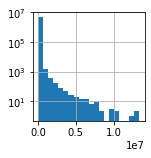

In [31]:
diff['diff'].hist(bins=20, log=True, figsize=(2,2))

In [32]:
diff['diff'].sum()

11829437839.051535

In [33]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments].sum()
for purpose in purposes:
    od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg.split('_')[0]==purpose]].sum(axis=1)
od_sum.drop(sm.segments, axis=1, inplace=True)
od_sum['root'] = od_sum.sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [34]:
od_sum.sample()

,,segment,commuting,business,education,buy/execute,leisure,accompany,root
,,sum,volume,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,,
DE406_5,DEA1B_5,rail_long,6.672307e-07,0.118956,1.109202e-08,0.000073,0.004826,0.257695,0.381551


In [35]:
# Add averages from following attributes
attrs = ['time', # hours per trip
         #'in_vehicle_time', # seconds per ride
         #'waiting_time', # seconds per ride
         'length', # Meter distance
         'ntransfers'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type']).mean()[attrs]
for attr in attrs:
    od_sum[('root', attr)] = means[attr]

In [36]:
# Convert units
od_sum[('root', 'length')] /= 1000
#od_sum[('root', 'in_vehicle_time')] /= 3600
#od_sum[('root', 'waiting_time')] /= 3600

In [37]:
# Compute passenger kilometer
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

In [38]:
# Load calibration dataset for modal split validation
mid_val = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid_val.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid_val['mode_agg'] = [mode_dict_mid[i] for i in mid_val.index]

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='business'>,
       <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='buy/execute'>, <AxesSubplot:ylabel='leisure'>,
       <AxesSubplot:ylabel='accompany'>], dtype=object)

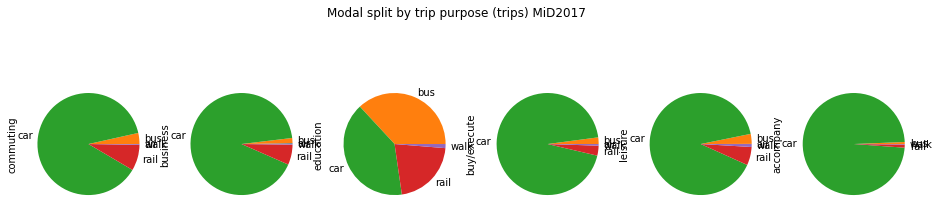

In [39]:
mid_val.groupby('mode_agg').sum()[purposes].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

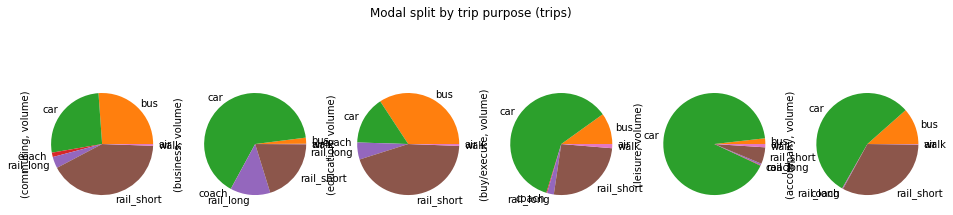

In [40]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [41]:
# MiD mode shares in percent
(mid_val.groupby('mode_agg').sum() /
 mid_val[purposes].sum() * 100)[purposes].round(2)

,commuting,business,education,buy/execute,leisure,accompany
mode_agg,,,,,,
air,0.00,0.26,0.00,0.01,0.05,0.00
bus,3.49,1.64,36.90,2.09,3.15,0.64
car,88.03,91.52,40.39,94.24,90.08,98.22
rail,8.22,6.38,21.42,3.14,5.79,0.98
walk,0.26,0.20,1.29,0.53,0.93,0.16


In [42]:
print('Model mode shares in percent')
print((od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum() /
       od_sum[[(seg, 'volume') for seg in purposes]].sum() * 100).round(2))

Model mode shares in percent
segment    commuting business education buy/execute leisure accompany
sum           volume   volume    volume      volume  volume    volume
mode                                                                 
air             0.00     0.09      0.00        0.00    0.01      0.00
bus            26.14     1.92     34.24        9.90    1.80     11.54
car            26.58    65.06     15.27       60.36   91.23     55.23
coach           1.38     0.02      0.00        0.27    0.17      0.07
rail_long       3.63    12.69      5.40        2.12    0.50      0.24
rail_short     41.71    20.14     44.50       26.02    5.27     32.76
walk            0.56     0.07      0.59        1.32    1.04      0.16


In [43]:
# MiD2017 mode shares - total
mid_val['sum'] = mid_val[purposes].sum(axis=1)
(mid_val.groupby('mode_agg').agg({'sum': 'sum'}) / mid_val['sum'].sum() * 100).round(2)

,sum
mode_agg,
air,0.03
bus,4.12
car,89.24
rail,6.03
walk,0.57


In [44]:
print('Model mode shares in percent - total')
print((od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2))

Model mode shares in percent - total
sum         volume   time  length  ntransfers    pkm
mode                                                
air           0.00   6.32    8.56       10.63   0.04
bus          10.42   0.39    0.10        0.99   6.77
car          62.89  24.45   34.52        0.00  63.46
coach         0.30  29.08   18.24       35.70   0.84
rail_long     1.91  28.08   30.10       34.08   3.76
rail_short   23.48  11.65    8.46       18.60  24.79
walk          1.00   0.03    0.01        0.00   0.34


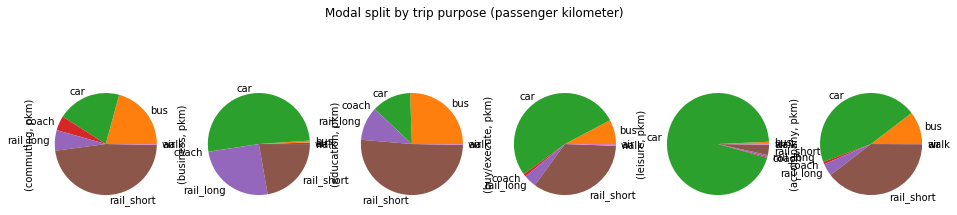

In [45]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (passenger kilometer)')
plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [46]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [47]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

In [48]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
#island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
#sm.car_los['o'] = sm.car_los['origin'].replace(island_dict).str[:5]
#sm.car_los['d'] = sm.car_los['destination'].replace(island_dict).str[:5]
#distances_agg = sm.car_los.groupby(['o', 'd']).agg({'length': 'mean'}) / 1000
#distances_agg.index.set_names(['origin', 'destination'], inplace=True)
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [49]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left',
                             left_on=['origin', 'destination'],
                             right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left',
                                     left_index=True,
                                     right_index=True)['length'],
                        bins=bins, labels=labels)

In [50]:
p_dict = {'commuting': 'Fz1', 'education': 'Fz2', 'buy/execute': 'Fz3',
          'business': 'Fz4', 'leisure': 'Fz6'}

In [51]:
if not 'rail' in od.columns.get_level_values(1):
    for p in purposes:
        od[(p, 'rail')] = od[(p, 'rail_short')] + od[(p, 'rail_long')]
        od[(p, 'bus')] = od[(p, 'bus')] + od[(p, 'coach')]

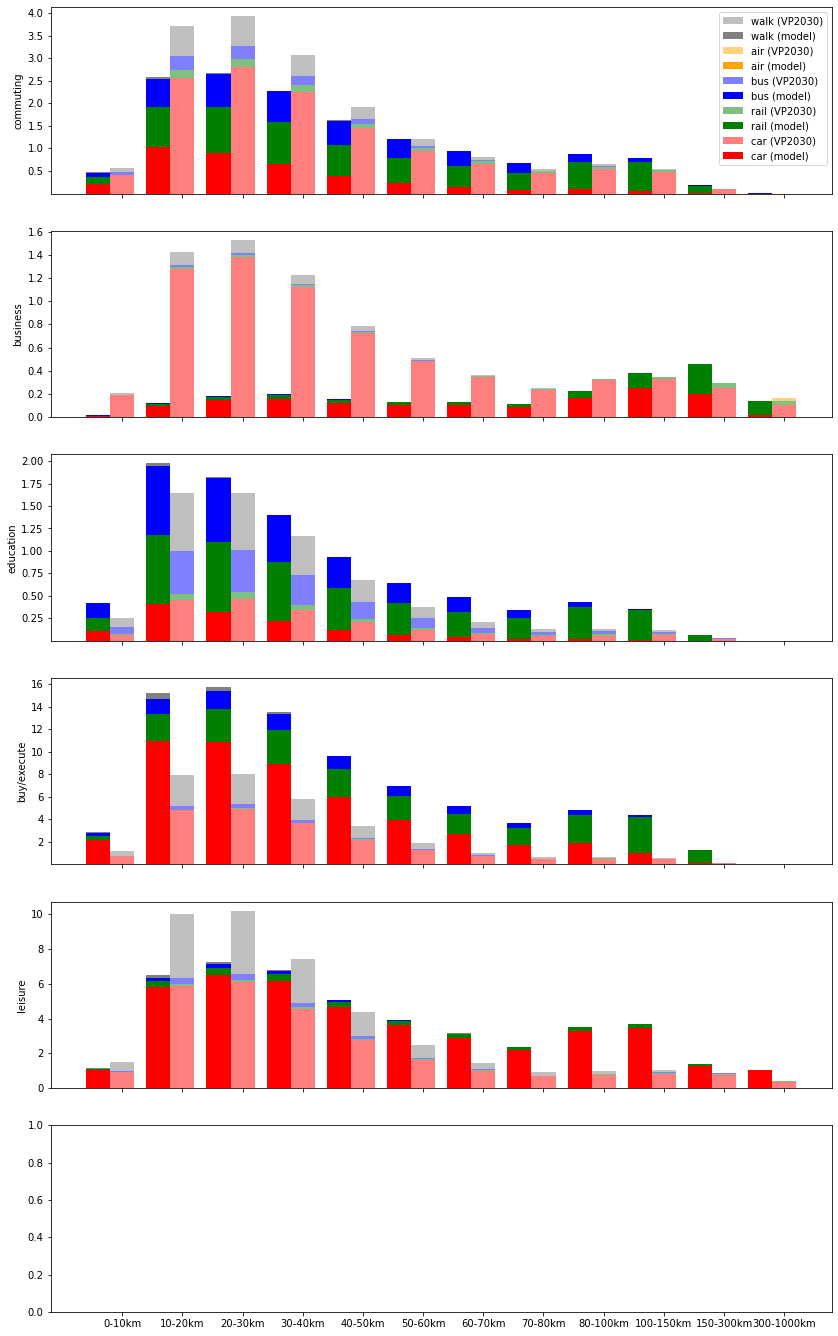

In [52]:
# Plot distance and mode distribution by segment
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
width = 0.4
ind = np.arange(len(labels))
if manual:
    fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                           figsize=(14,len(purposes)*4),
                           sharex='all', sharey='row')
    for seg in range(len(purposes[:-1])):
        model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
        vp_vols = [vp_binned[(p_dict[purposes[seg]], mode)] for mode in modes]
        for i in range(len(modes)):
            if i==0:
                model_bottom = 0
                vp_bottom = 0
            else:
                model_bottom = sum(model_vols[:i])
                vp_bottom = sum(vp_vols[:i])
            ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                        width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
            ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                        width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
        ax[seg].set_ylabel(purposes[seg])
    h, l = ax[0].get_legend_handles_labels()
    ax[0].legend(h[::-1], l[::-1])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030.png', dpi=300)

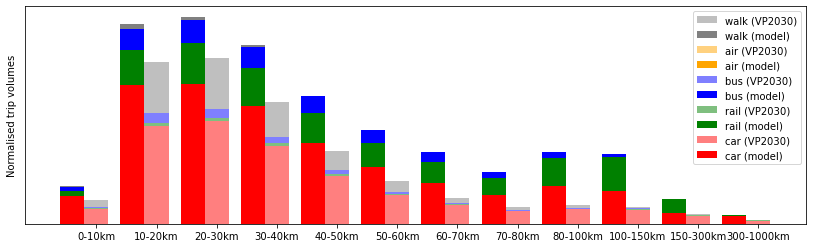

In [53]:
# Plot distance and mode distribution all together
if manual:
    fig, ax = plt.subplots(figsize=(14,4))
    model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
    vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax.bar(ind, model_vols[i], bottom=model_bottom,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax.bar(ind+width, vp_vols[i], bottom=vp_bottom, alpha=.5,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax.set_ylabel('Normalised trip volumes')
    ax.set_yticks([])
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-1], l[::-1])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030_all.png', dpi=300)

In [54]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])

In [55]:
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']
                                     ).index.map(distances.to_dict()['length'])
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_model']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [56]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean()
                     / mid2017.mean().mean())

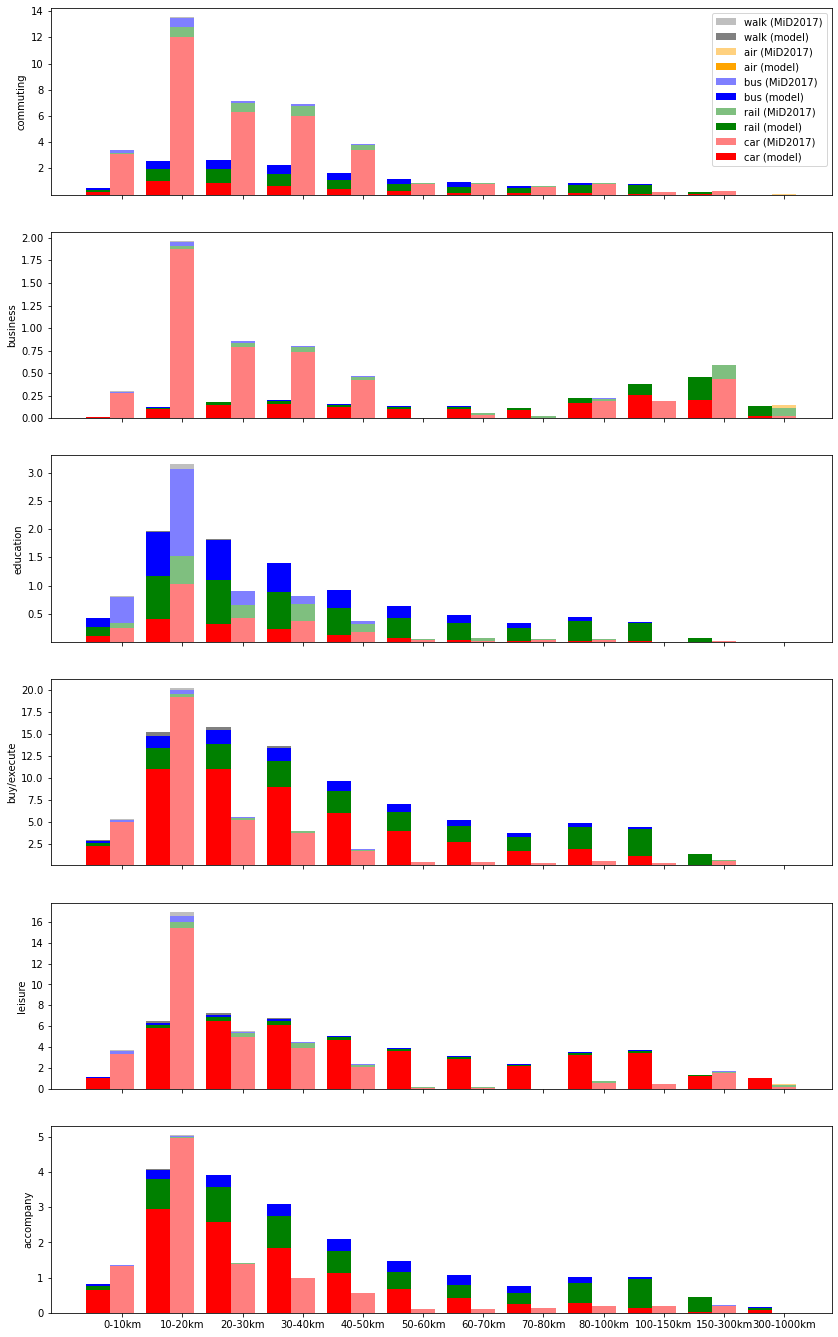

In [57]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(purposes[seg], mode)] for mode in modes]
    width = 0.4
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=300)

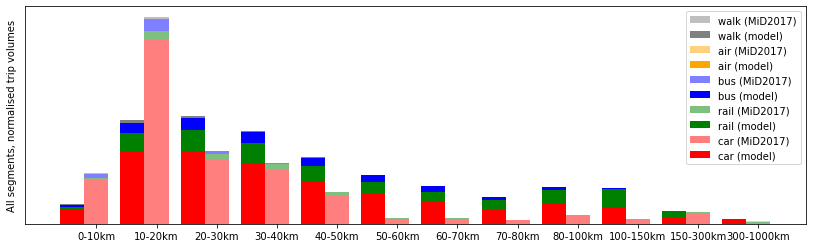

In [58]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
width = 0.4
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        mid_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
ax.set_ylabel('All segments, normalised trip volumes')
ax.set_yticks([])
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=300)

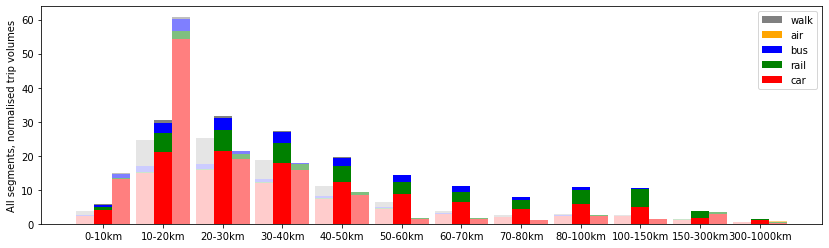

In [59]:
# Plot distance and mode distribution for all three data sources
if manual:
    fig, ax = plt.subplots(figsize=(14,4))
    width = 0.3
    vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
    model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
    mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
    for i in range(len(modes)):
        if i==0:
            vp_bottom = 0
            model_bottom = 0
            mid_bottom = 0
        else:
            vp_bottom = sum(vp_vols[:i])
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax.bar(ind-width, vp_vols[i], bottom=vp_bottom, alpha=.2,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
        ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
               width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
        ax.bar(ind, model_vols[i], bottom=model_bottom,
               width=width, tick_label=labels, color=colors[i], label=modes[i])#+' (model)')
    ax.set_ylabel('All segments, normalised trip volumes')
    h, l = ax.get_legend_handles_labels()
    ax.legend(h[::-3], l[::-3])
    plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_VP2030_all.png', dpi=300)

In [60]:
# Difference in the largest distance segment in % to MiD2017
(sum(model_vols.T[-1]) - sum(mid_vols.T[-1])) / sum(mid_vols.T[-1])

0.9655120683947686

In [61]:
od_sum.xs('car', level=2)[('root', 'volume')].sum() / 1e6

11829.437839051503

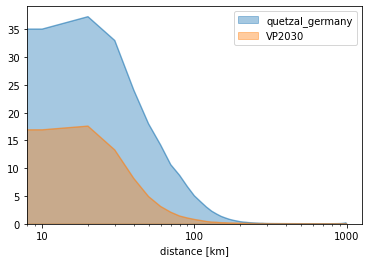

In [62]:
# Sum up volumes of the model and VP2030
if manual:
    vol_df = pd.DataFrame(od[[c for c in od.columns
                              if c[0] in purposes and c[1]!='walk']
                            ].sum(axis=1).rename('quetzal_germany'))
    vol_df['VP2030'] = vp2017[[c for c in vp2017.columns
                               if c[0].startswith('Fz') and c[1]!='walk']
                             ].sum(axis=1)
    # Create distance classes
    dist_classes = list(range(0, 1011, 10))
    vol_df['distance [km]'] = pd.cut(vol_df.merge(distances, how='left',
                                                   left_index=True, right_index=True
                                                  )['length'],
                                     bins=dist_classes,
                                     labels=dist_classes[:-1])
    # Scaled normalised volumes: erronous, don't use them
    vol_df.groupby('distance [km]').agg({'quetzal_germany': 'sum', 'VP2030': 'sum'}
                                       ).plot(kind='area', stacked=False, alpha=.4,logx=True)

In [63]:
# Function to plot a traffic map
def plot_traffic(ax):
    pt_mask = (sm.links['volume'].notna()) & (sm.links['volume']>0)
    road_mask = (sm.road_links['volume'].notna()) & (sm.road_links['volume']>0)
    scaler = max(sm.links['volume'].max(), sm.road_links['volume'].max()) / 50
    sm.links.loc[pt_mask, ['geometry']].plot(
        alpha=.5, color=blue, linewidth=list(sm.links.loc[pt_mask, 'volume']/scaler*2),
        ax=sm.road_links.loc[road_mask, ['geometry']].plot(
            alpha=.3, color='red',
            linewidth=list(sm.road_links.loc[road_mask, 'volume']/scaler),
            ax=sm.zones.plot(alpha=.2, color='green', ax=ax)))

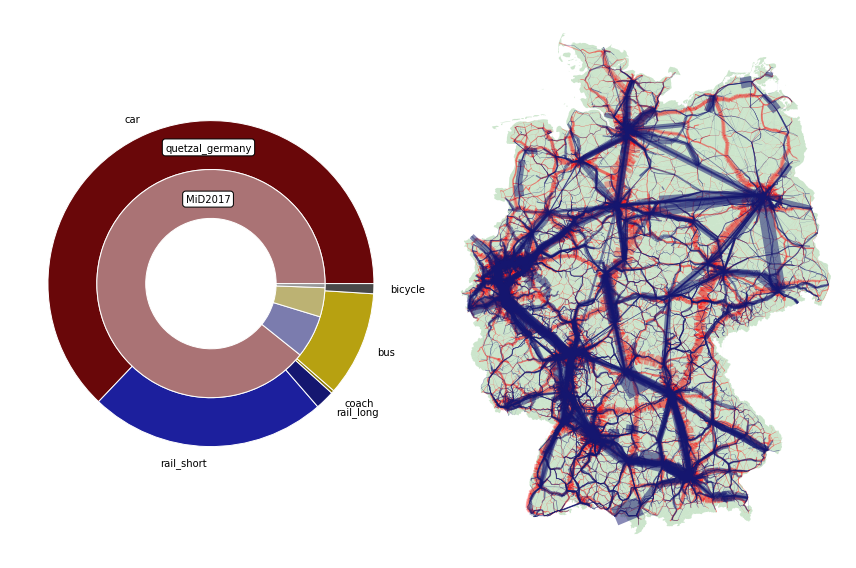

In [64]:
# Figure for publication
if manual:
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
    red = '#690709'
    blue = '#151770'
    blue2 = '#1C1F9D'
    grey = '#494949'
    yellow = '#887706'
    yellow2 = '#B7A111'
    light = '#bdbdbd'
    red_ = '#6907098F'
    blue_ = '#1517708F'
    grey_ = '#4949498F'
    yellow_ = '#8877068F'
    light_ = '#bdbdbd8F'

    # double ring: Mode split model vs. MiD2017
    ax[0].axis('equal')
    width = 0.3
    model_values = od_sum[('root', 'volume')].groupby(level=2).sum().loc[
        ['car', 'rail_short', 'rail_long', 'coach', 'bus', 'walk']
    ].rename(index={'walk': 'bicycle'})
    pie, _ = ax[0].pie(model_values, labels=model_values.index,
                       radius=1,
                       colors=[red, blue2, blue, yellow, yellow2, grey])
    plt.setp( pie, width=width, edgecolor='white')
    ax[0].annotate(
        'quetzal_germany', xy=(-0.28, .82),
        bbox=dict(boxstyle="round", fc="white", lw=None, alpha=1)
    )
    mid_values = mid_val.groupby('mode_agg').sum()[purposes].sum(axis=1).loc[
        ['car', 'rail', 'bus', 'walk']]
    pie2, _ = ax[0].pie(mid_values,# labels=mid_values.index,
                        radius=1-width, labeldistance=0.7,
                        colors=[red_, blue_, yellow_, grey_])
    plt.setp( pie2, width=width, edgecolor='white')
    ax[0].annotate(
        'MiD2017', xy=(-0.155, .5),
        bbox=dict(boxstyle="round", fc="white", lw=None, alpha=1)
    )

    plot_traffic(ax[1])
    ax[1].axis('off')
    fig.tight_layout()
    plt.savefig(output_path + scenario + '/' + 'validation_mode_shares_traffic.png', dpi=400)

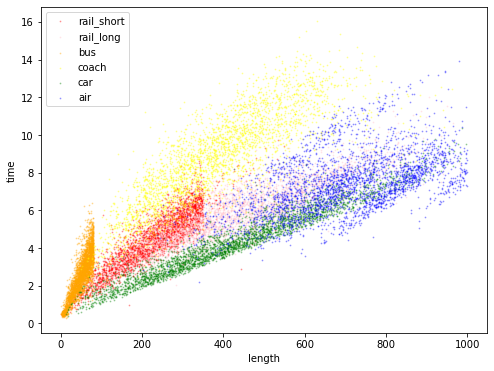

In [65]:
# How do the LoS attributes look like again?
if manual:
    fig, ax = plt.subplots(figsize=(8,6))
    c_dict = {'rail_short': 'red', 'rail_long': 'pink', 'bus': 'orange',
              'coach': 'yellow', 'car': 'green', 'air': 'blue'}
    sm.los['length'] = sm.los['length'] / 1000
    for m in c_dict.keys():
        size = min(3000, len(sm.los.loc[sm.los['route_type']==m]))
        sm.los.loc[sm.los['route_type']==m].sample(size).plot(
            ax=ax, kind='scatter', x='length', y='time', s=.8, c=c_dict[m], alpha=.3, label=m)
    plt.legend()
    plt.savefig(output_path + scenario + '/' + 'LoS_attributes.png', dpi=300)
    sm.los['length'] = sm.los['length'] * 1000


### Excel export

What do we need as outputs for energy and emission modelling? Most commonly, energy system models minimise total system cost under the constraint of emissions reduction towards a given goal. Costs include investments into vehicles (sometimes even infrastructure) and operating cost of these vehicles. Demand for transport is exogenously defined as activity rates per vehicle technology type in each time step. This model can contribute:
* passenger kilometer per mode and zone
* user cost, which can be translated into operating cost

In [66]:
# Keep only the aggregation of all purposes
od = od_sum.loc[:, 'root']

In [67]:
# Aggregated modal split in million pkm by main mode
od.groupby(level=2).sum()['pkm'] / 1e6

mode
air              336.436222
bus            64875.238407
car           608523.275028
coach           8069.792354
rail_long      36100.906876
rail_short    237762.569748
walk            3270.634187
Name: pkm, dtype: float64

In [68]:
# Aggregated pkm (million)
od.groupby(level=2).sum()['pkm'].sum() / 1e6

958938.8528205474

In [69]:
# Total volumes between model zones (million)
sm.los['volume'].sum()/1e6

18808.685256504643

In [70]:
# Volumes between NUTS3-level (million)
sm.los.loc[sm.los['origin'].str[:5]!=sm.los['destination'].str[:5], 'volume'].sum() / 1e6

15863.224501874818

In [71]:
# Reduce table size by mapping origin and destination to bigger zones
od.reset_index(drop=False, inplace=True)
od['origin'] = od['origin'].str[:3] # NUTS1
od['destination'] = od['destination'].str[:3]

In [72]:
# Calculate weighted averages by zone aggregation
od['volume'] += 1e-6 # prevent weights being zero in sum
weighted_av = lambda x: np.average(x, weights=od.loc[x.index, 'volume'])
od = od.groupby(['origin', 'destination', 'mode']).agg(
    volumes=('volume', 'sum'),
    time=('time', weighted_av),
    #in_vehicle_time=('in_vehicle_time', weighted_av),
    length=('length', weighted_av)
)

## Save model

In [73]:
with pd.ExcelWriter(output_path + scenario + '/' + 'inter_zone.xlsx') as writer:
    od.to_excel(writer, sheet_name='od')

In [74]:
sm.to_zippedpickles(model_path + 'de_assignment',
                    only_attributes=['links', 'nodes', 'road_links', 'volumes'])

los: 100%|█████████████████████████████████████████████████████████████████████████████| 16/16 [01:01<00:00,  3.83s/it]


In [75]:
# Save distances between centroids in km
if manual:
    (car.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
    ).astype(int).to_csv(output_path + 'distances_centroids.csv')